<a href="https://colab.research.google.com/github/d61h6k4/EML/blob/main/CrossNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from matplotlib import pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import ShuffleSplit

In [ ]:
X, Y = load_diabetes(return_X_y=True)
train_idx, test_idx = next(ShuffleSplit(n_splits=1, test_size=0.2).split(X, Y))
train_idx, val_idx = next(ShuffleSplit(n_splits=1, test_size=0.2).split(X[train_idx], Y[train_idx]))
X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
Y_train, Y_val, Y_test = Y[train_idx], Y[val_idx], Y[test_idx]

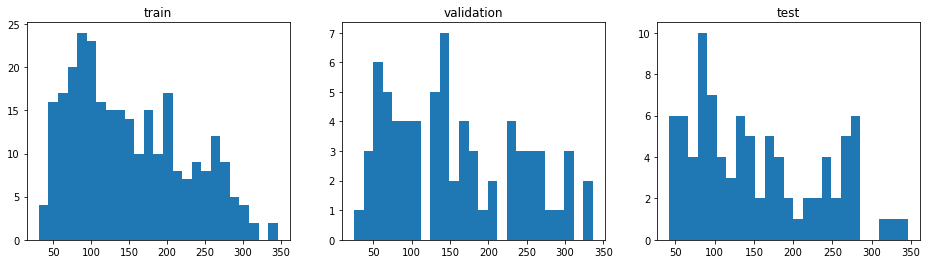

In [ ]:
fig, axs = plt.subplots(figsize=(16, 4), ncols=3)


axs[0].hist(Y_train, bins=25)
axs[0].set_title("train")

axs[1].hist(Y_val, bins=25)
axs[1].set_title("validation")

axs[2].hist(Y_test, bins=25)
axs[2].set_title("test")

fig.show()

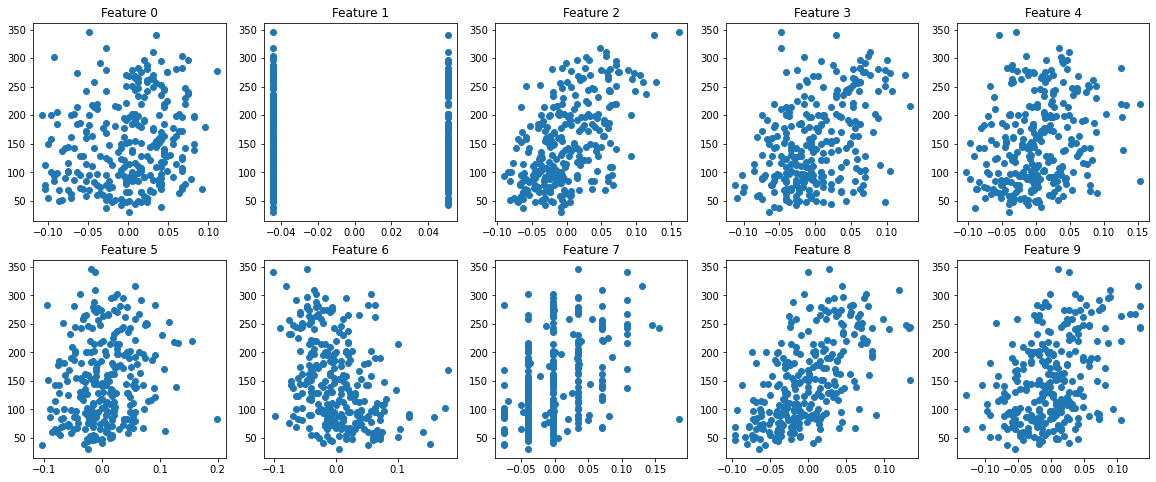

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

for i in range(X_train.shape[1]):
    axs[int(i / 5)][int(i % 5)].scatter(X_train[:, i], Y_train)
    axs[int(i / 5)][int(i % 5)].set_title(f"Feature {i}")

fig.show()

### Model

In [ ]:
import torch

from torch import Tensor
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.nn.parameter import Parameter

In [ ]:
class CrossNetwork(nn.Module):
    def __init__(self, features_dim: int, layers_num: int):
        super().__init__()
        self.layers = [nn.Linear(features_dim, features_dim) for _ in range(layers_num)]

    def forward(self, input: Tensor) -> Tensor:
        x_0 = input
        x = x_0
        for layer in self.layers:
            x = x_0 * layer(x) + x
        return x 

In [ ]:
model = torch.nn.Sequential(torch.nn.Linear(10, 30),
                            CrossNetwork(30, 3),
                            torch.nn.Tanh(),
                            torch.nn.Linear(30, 10),
                            torch.nn.Tanh(),
                            torch.nn.Linear(10, 1))


### Training

In [ ]:
batch_x = torch.from_numpy(X_train).float()
batch_y = torch.from_numpy(Y_train).unsqueeze(dim=1).float()

In [ ]:
steps_num = 200_000

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=0.01)
for ix in range(steps_num):
    optimizer.zero_grad()

    y_pred = model(batch_x)
    output = torch.abs(y_pred - batch_y).mean()

    output.backward()
    optimizer.step()
    
    if ix % 5000 == 0:
        print(f"step: {ix} train: {output.item()}")
        if ix % 10_000 == 0:
            with torch.no_grad():
                print("\teval: ", torch.abs(model(torch.from_numpy(X_val).float()) - torch.from_numpy(Y_val).unsqueeze(dim=1).float()).mean().item()) 

step: 165000 train: 2.3564019203186035
step: 170000 train: 2.009408712387085
	eval:  58.61663818359375
step: 175000 train: 2.6045210361480713
step: 180000 train: 2.0180749893188477
	eval:  58.89566421508789
step: 185000 train: 2.0869860649108887
step: 190000 train: 1.965997576713562
	eval:  59.096920013427734
step: 195000 train: 1.850232720375061


### Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
with torch.no_grad():
    print("mse = ", mean_squared_error(model(torch.from_numpy(X_test).float()), Y_test))
    print("mae = ", mean_absolute_error(model(torch.from_numpy(X_test).float()), Y_test))

mse =  2069.122393367505
mae =  24.255343276463197


In [ ]:
model(torch.from_numpy(X_test).float())[:7,:], Y_test[:7]

(tensor([[137.4359],
         [150.4846],
         [ 85.5990],
         [ 87.6543],
         [ 48.5880],
         [176.8821],
         [134.0762]], grad_fn=<SliceBackward0>),
 array([137., 252.,  85.,  88.,  63., 179., 135.]))

In [ ]:
with torch.no_grad():
    print("mse = ", mean_squared_error(model(torch.from_numpy(X_test).float()), Y_test))
    print("mae = ", mean_absolute_error(model(torch.from_numpy(X_test).float()), Y_test))

mse =  2994.3656361824355
mae =  32.51195252879282
